<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Rapid warming of sea surface temperatures is alarming scientists as temperature recordings from a globally distributed of NOAA buoys rise higher than expected for this time of year. In this post, I use the previously discussed Variational inference model in combination with Extreme value theory (EVT) as an anomaly detection method to explore these extreme outlier values.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [15]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44007/44007.ncml')
ds = ds.sel(time=slice('2021-3-30','2023-4-25'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 108912)
Coordinates:
  * latitude                 (latitude) float32 43.53
  * longitude                (longitude) float32 -70.14
  * time                     (time) datetime64[ns] 2021-03-30 ... 2023-04-25T...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tem

In [16]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
print(cov)

                      time  sea_surface_temperature
0      2021-03-30 00:00:00                      5.1
1      2021-03-30 00:10:00                      5.1
2      2021-03-30 00:20:00                      5.1
3      2021-03-30 00:30:00                      5.1
4      2021-03-30 00:40:00                      5.1
...                    ...                      ...
108285 2023-04-25 23:10:00                      6.7
108286 2023-04-25 23:20:00                      6.8
108287 2023-04-25 23:30:00                      6.9
108288 2023-04-25 23:40:00                      6.9
108289 2023-04-25 23:50:00                      6.9

[108290 rows x 2 columns]


In [17]:
# Fit mixture model 
num_components = 2
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[65054. 43236.]


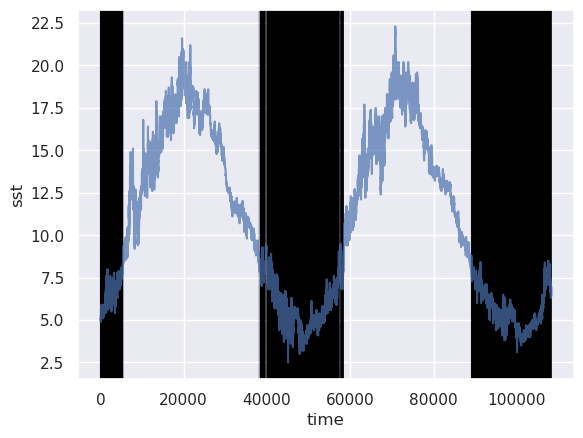

In [18]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

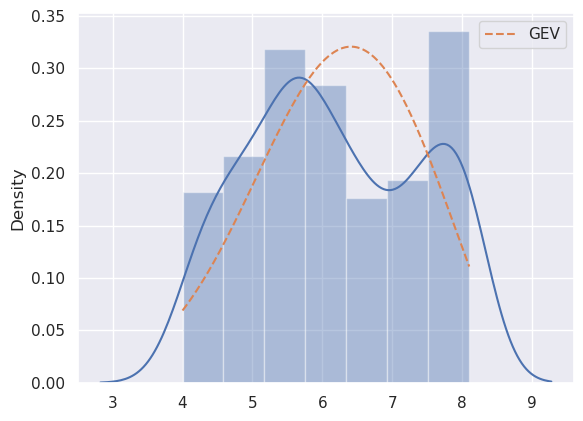

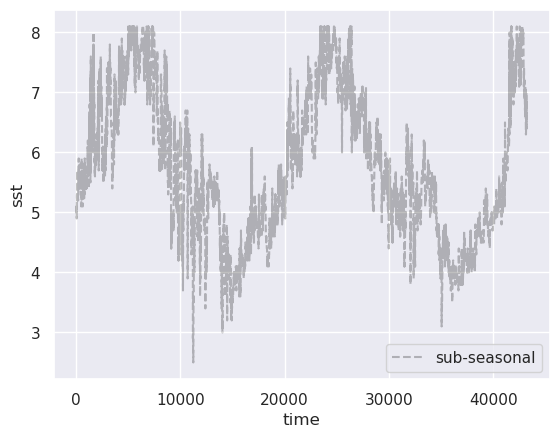

--score--
7.1
0.2775357699224991


In [20]:
# Plot a gumbel GEV distribution
data = []
gev = []

# Block maxima approach
win_len = 6*24
block_maxima = lambda serie:[ max(serie[(BL * win_len) : (BL * win_len) + win_len]) 
                                        for BL in range(0, int(len(serie)/ win_len)) ]

# Gather up data 
for M in range(len(p)): 
  if p[M] == p[-1]:
    v = cov['sea_surface_temperature'].values[M]
    data.append(v)

# Find block maxima and fit GEV 
gev = block_maxima(data)
gev_fit = stats.genextreme.fit(gev)
x = np.linspace(min(gev), max(gev), 200)

# GEV 
fig,ax = plt.subplots()
sns.distplot(gev)
plt.plot(x, stats.genextreme.pdf(x, *gev_fit), linestyle='--', label='GEV')
plt.legend()
plt.show()

# sub-seasonal data 
sns.lineplot(data=data, color='black', alpha=0.25, linestyle='--', label='sub-seasonal')
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

# score the most recent block maxima 
print('--score--')
print(gev[-1])
print(stats.genextreme.pdf(gev[-1], *gev_fit))